# **TRANSFER LEARNING**

Existem diversas arquiteturas de CNN, cada rede com suas próprias características, principalmente para visão computacional. Mas todas tem em comum camadas de convolução, pooling e dropout.

## **Por que utilizar uma arquitetura CNN já existente?**
Porque possibilita reduzir o tempo de pesquisa e desenvolvimento de novas arquiteturas, umas vez que essas já foram sistematicamente revisadas e treinadas para um problema específico.

O treinamento de uma boa CNN não é simples, pois além de muito tempo para processamento, ainda requer milhares de imagens como dados de treino e poder computacional.

Uma forma de contornar esse problema é a utilização de redes pré-treinadas com conjunto de dados de milhares de imagens e com uma arquitetura adequada, o que garante uma boa acurácia e previni um overfitting.



In [25]:
# Códigos Uteis
def plot_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('epoch')
  plt.legend(['loss','val_loss'], loc='lower left')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('epoch')
  plt.legend(['acc','val_acc'], loc='upper left')
  plt.show()

In [2]:
# Importar as bibliotecas
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Carrega o dataset, fazendo a separação dos dados em treino, validaçao e teste
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteUBYR3O/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


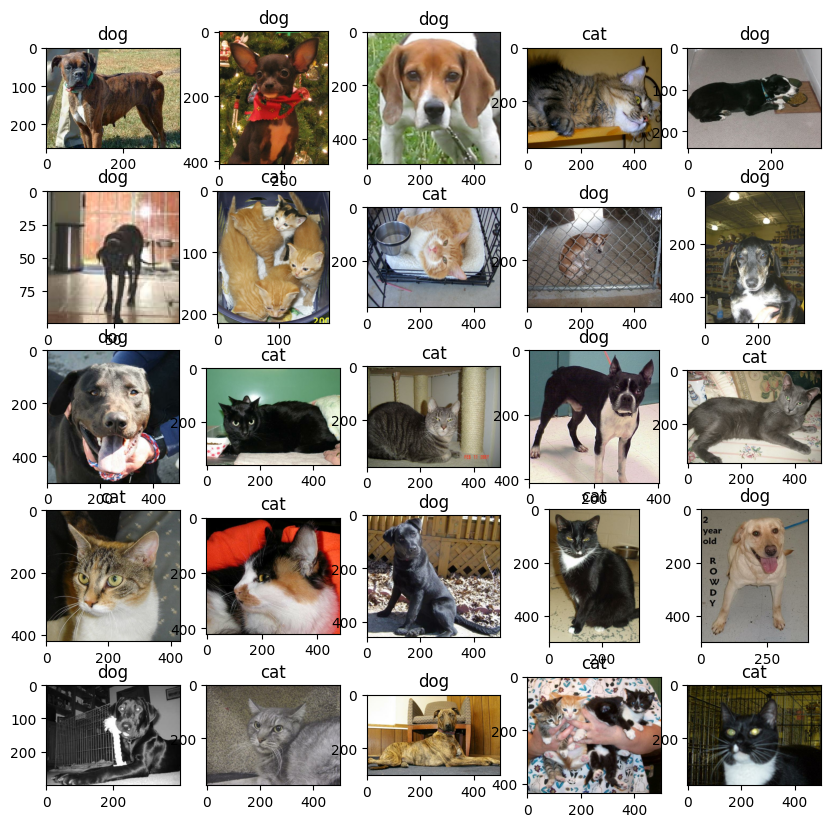

In [9]:
# Criando uma função para pegar os labels das imagens
get_label_name = metadata.features['label'].int2str  

# Mostrando as imagens do dataset
plt.figure(figsize = (10,10))
i = 0
for image, label in raw_train.take(25):
  plt.subplot(5,5,i+1)
  plt.imshow(image)
  plt.title(get_label_name(label))
  i = i + 1

In [10]:
# Definindo uma funçao para redimensionar as imagens

IMG_SIZE = 160 #  160x160
def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [11]:
# Redimensionando as imagens
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

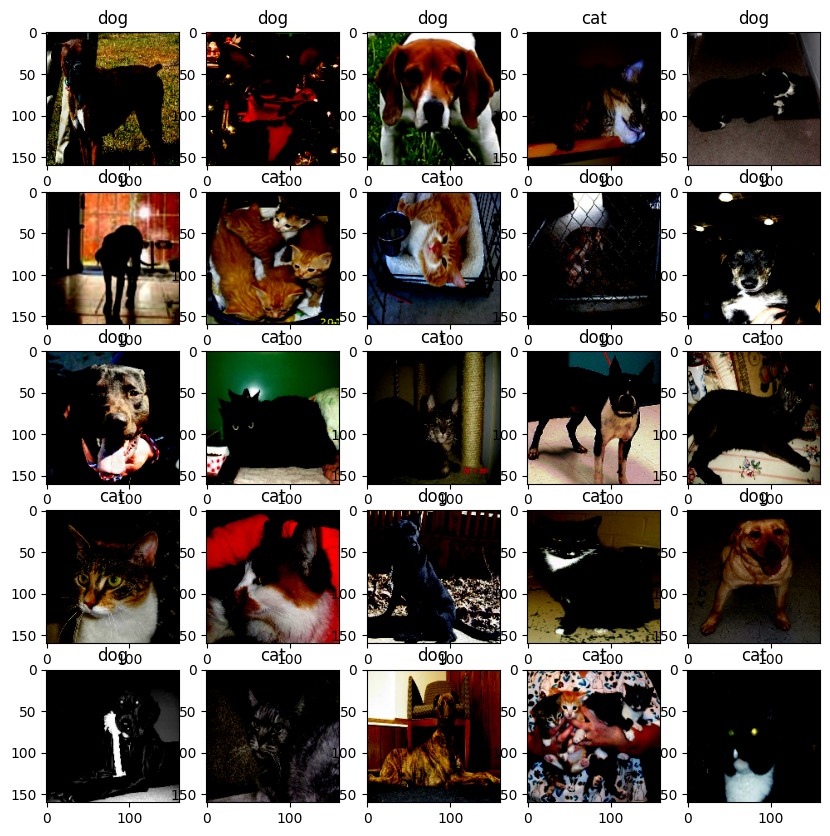

In [13]:
# Mostrando as imagens do dataset
plt.figure(figsize = (10,10))
i = 0
for image, label in train.take(25):
  plt.subplot(5,5,i+1)
  plt.imshow(image)
  plt.title(get_label_name(label))
  i = i + 1

In [14]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

#embaralha as imagens e separa em batchs
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## **Escolhendo um modelo pré-treinado**
A MobileNet V2 foi desenvolvido no Google e treinado com 1,4 milhão de imagens, com 1.000 classes diferentes e com pesos predeterminados do imagenet (Googles dataset)./

In [15]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Cria o base_model referente a MobileNet V2, sem a camada de classificação
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [16]:
# Mostrando a arquitetura do modelo
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Vamos analisar os parametros do nosso modelo:

Total params: 2,257,984
Trainable params: 2,223,872
Non-trainable params: 34,112

Ele está dizendo que temos pouco mais de 2 milhoes de parâmetros, sendo que cerca de 34 mil não permitem treinamento, nos restando aproximadamente 2 milhões que podem ser treinados.

Mas a vantagem de usar essa rede é justamente aproveitar os pesos que já foram treinados, e não retreina-los! Precisamos congelar os pesos originais para evitar o processo de treino novamente.

In [17]:
#Congela a base_model para não atuaizar os pesos quando treinar.
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

## **Adicionando um Classificador**

Até o momento só carregamos uma CNN pré treinada, mas note que ela só tem as camadas de convolução, pooling e outras técnicas aplicadas a CNN. Ela não possui a ultima camada de classificação!

É nessa camada em que é realizada a especificação do nosso modelo, por isso, precisamos incluir agora as camadas de classificação:

In [18]:
# Camada  para gerar um vetor de 1280 elementos 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# O Classificador para gato cachorro com 1 neuronio 
prediction_layer = keras.layers.Dense(1)

# Por fim, vamos criar a nossa rede neural com o modelo CNN e com as camadas de classificação que definimos
model = tf.keras.Sequential([
  base_model,           #### cnn mobilenet
  global_average_layer, ###flatten
  prediction_layer      ### especiallista
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## **Pronto! Já criamos a nossa rede para classificação. Agora podemos treinar nossa rede e testar.**

### **Treinando o Modelo**

In [21]:
# Compilando o modelo
tf.random.set_seed(42)
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
#Avaliação do modelo antes de treiná-lo com novas imagens
initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 3s 71ms/step - loss: 0.7086 - accuracy: 0.5281


In [23]:
# Treinamento da nova CNN
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 41s 63ms/step - loss: 0.2014 - accuracy: 0.9084 - val_loss: 0.0922 - val_accuracy: 0.9647
Epoch 2/3
582/582 [==============================] - 37s 61ms/step - loss: 0.0749 - accuracy: 0.9725 - val_loss: 0.0659 - val_accuracy: 0.9751
Epoch 3/3
582/582 [==============================] - 39s 65ms/step - loss: 0.0595 - accuracy: 0.9776 - val_loss: 0.0568 - val_accuracy: 0.9781


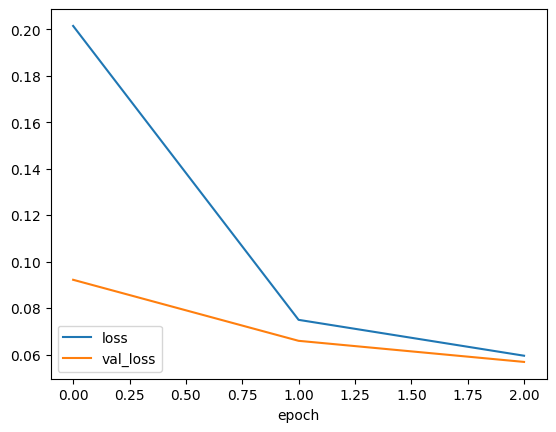

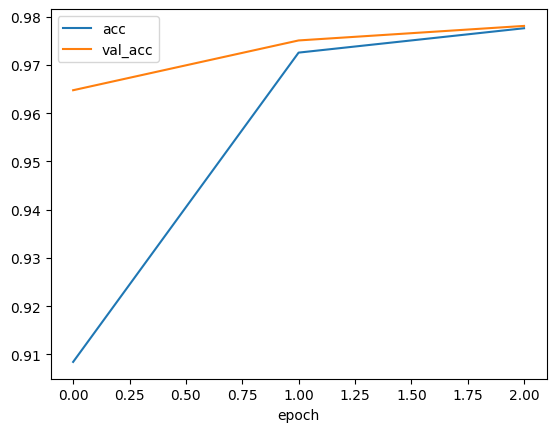

In [27]:
# Plotando a acuracia e a Loss
plot_history(history)

## **Fazendo Predições**

In [28]:
# Selecionando algumas imagens do set de teste
image_batch, label_batch = test_batches.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Aplique um sigmoide, pois nosso modelo retorna logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
Labels:
 [0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]


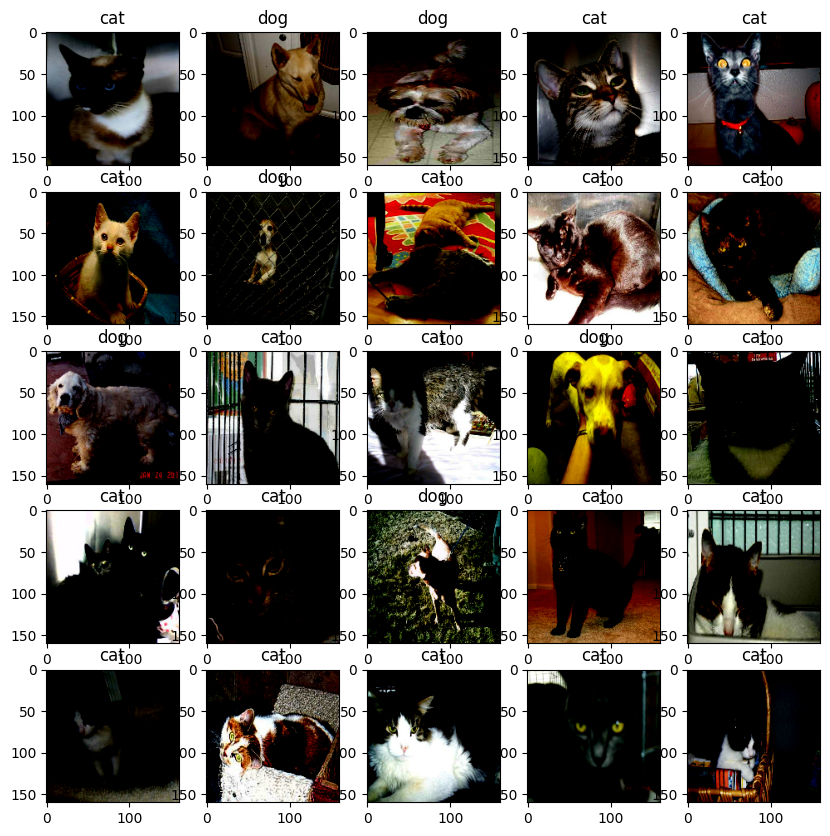

In [29]:
# Mostrando as imagens do dataset
plt.figure(figsize = (10,10))
i = 0
for image, label in test.take(25):
  plt.subplot(5,5,i+1)
  plt.imshow(image)
  plt.title(get_label_name(label))
  i = i + 1

## **Salvando o modelo**

In [30]:
# Salvando a rede 
model.save("dogs_vs_cats.h5")

#Carregando uma rede .h5
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')